In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__
print(device)

cuda


## Utils and Input & Output Process

In [2]:
# ============================== Utils =========================================
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    if ('val_categorical_accuracy' in history.history.keys()):
        plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if ('val_loss' in history.history.keys()):
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def adBits(x, x2, y, seqsize=100):
   for i in range(x.shape[0]):
      #print(' for each train sample  ... ', i)
      loop = seqsize
      j = 0
      for loop in range(seqsize):     
          #print(' for each node ... ', j)
          adBits_1 = int(x[i][2*loop])
          #Get the next LONG since each node now has 2 LONGs for adj edges
          adBits_2 = int(x[i][2*loop+1])
          # Uncomment below if you want invalid nodes to not feed to NN before any valid nodes
          #if (adBits_1==0 and adBits_1==0 and loop!=seqsize-1):              
          #    y[i][j] = y[i][loop+1] 
          #    continue
          if (adBits_1):
              #print adBits
              for k in range(0,64):
                  bit = adBits_1 & 1
                  #print ( ' adBits&1 = ',  bit )
                  # Uncomment below if you want new nodes to only have adjacency to earlier nodes
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_1 >>= 1
              x2[i][j][j] = 1 

          if (adBits_2):   
              #print adBits
              for k in range(64,100):
                  bit = adBits_2 & 1
                  #print ( ' adBits&1 = ',  bit )
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_2 >>= 1
              x2[i][j][j] = 1
          j = j+1
   return x2, y

def updateLabelBits(x, y, seqsize=100):
    for i in range(x.shape[0]):
        #print(' for each train sample  ... ', i)
        label_dict = {}
        label_num = 1
        for j in range(seqsize):
            if (x[i][j][j] == 0):
                y[i][j] = 0
            else:
                if y[i][j] in label_dict:
                    y[i][j] = label_dict[y[i][j]]
                else:
                    label_dict[y[i][j]] = label_num
                    y[i][j] = label_num
                    label_num = label_num + 1
    return y

# ============================== Post Process ==================================



def post_process (x2_pred, predicted, seqsize=100):
    #Calculate the number of edges which will require correction
    invCols = 0
    edges = 0
    for i in range(x2_pred.shape[0]):
        for j in range(seqsize): # row
            for k in range(j): # col
                adj = x2_pred[i][j][k]
                if (adj == 1):
                    edges += 1
                    if (np.argmax(predicted[i][j]) == np.argmax(predicted[i][k])):
                        invCols += 1
                        
    print('Total No of edges ', edges)
    print('# of edges with invalid coloring ', invCols)
    print('Total percentage of edges with invalid colors ', invCols/edges)

def post_process_chromatic (x2_pred, predicted, seqsize=100):  
    colors_list_list = []
    for i in range(x2_pred.shape[0]):
        colors_list = []
        for j in range(seqsize):
            # Valid nodes will have below set to 1 so check the color 
            # assignment of those nodes only
            if (x2_pred[i][j][j] != 0):
                colors_list.append(np.argmax(predicted[i][j]))
        print('Colors list of graph ', i, ' is  \n', colors_list)
        chromatic_number = len(set(colors_list))
        print('Chromatic number of graph ', i, ' is  ', chromatic_number)
        colors_list_list.append(colors_list)
    return colors_list_list

def create_csv_rows(graph_name, colors_list_list_before_correction, 
                     colors_list_list_after_correction):
    csv_rows = []    
    for i in range(len(colors_list_list_before_correction)):
        row = [graph_name, i, len(set(colors_list_list_before_correction[i])), 
               len(set(colors_list_list_after_correction[i]))]        
        csv_rows.append(row)
    return csv_rows

def post_process_correction (x2_pred, predicted, colors_list_list, seqsize=100): 
  totInvCols = 0
  totEdges = 0

  for i in range(x2_pred.shape[0]):
      #maxcol = max(xpredicted[i])
      maxcol = max(colors_list_list[i])
      #print(maxcol)
      #mcol = maxcol[0]
      maxorigcol = maxcol
      mcolnew = maxcol
      #print('Maxcol = ',maxcol[0])
      #print(' ... FOR SAMPLE  ... ', i)
      invCols = 0
      edges = 0;
      newCol = 500

      for j in range(seqsize):
          #print(' ... ... FOR EACH NODE ... ...', j)
          for k in range(j):
              #print(' ... ... ... for each adjacency  ... ... ...', k)
              adj = x2_pred[i][j][k]
              #There is an edge
              if ( adj == 1 ):
                  edges += 1
                  if ( np.argmax(predicted[i][j]) == np.argmax(predicted[i][k]) ):                   
                      col_j = np.argmax(predicted[i][j])
                      col_k = np.argmax(predicted[i][k])
                      invCols += 1

                      #Check whether we can give one of the existing colors
                      foundfinalcol = 0
                      for  y in range(1,maxcol+1):
                          #print('Check for COLOR NO ... ', y)
                          if ( foundfinalcol == 1 ) :
                              #print('FOUND COLOR ALREADY  ... leave the loop')
                              break

                          foundcol = 0
                          #Check the adjacent nodes of j
                          #for  z in range(j):
                          for z in range(seqsize):
                              if j!=z:
                                  if  (   ((x2_pred[i][j][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                      or  ((x2_pred[i][z][j] == 1) and (np.argmax(predicted[i][z]) == y))
                                      ):
                                      #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                      foundcol = 1
                                      #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                      break

                          #Finished checking the adjacent nodes of j
                          #Color y is not used by any of j's neighbours
                          #print('[1] Finished Checking the adjacent node of ... ',j,' ... foundcol = ',foundcol)
                          if ( foundcol == 0 ) :
                              #assign any prediction > 1
                              predicted[i][j][y] = 2
                              #print('[1] Reuse color ', y, ' for node ', j)
                              foundfinalcol = 1

                          else :
                              foundcol = 0                                                            
                              #Check the adjacent nodes of k
                              for z in range(seqsize):
                                  if k!=z:
                                      if  (   ((x2_pred[i][k][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                          or  ((x2_pred[i][z][k] == 1) and (np.argmax(predicted[i][z]) == y))
                                          ):
                                          #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                          foundcol = 1
                                          #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                          break
                              #Color y is not used by any of k's neighbours
                              if ( foundcol == 0 ) :
                                  #assign any prediction > 1
                                  predicted[i][k][y] = 2
                                  #print('[2] Reuse color ', y, ' for node ', k )
                                  foundfinalcol = 1

                      # Could not color using an existing color
                      # Get a new color from 500 onwards OR use from the new 500 color number series
                      if ( foundfinalcol == 0 ) :
                           #newCol += 1
                           mcolnew += 1
                           #assign any prediction > 1
                           predicted[i][k][mcolnew] = 2
                           maxcol +=1
                           #print('Use new color ', mcolnew, ' for node ', k)

  return predicted



## Data Process

In [3]:
seq_size = 100
seq = pd.read_csv("train_data.csv",header=None,low_memory=False)
columns = seq.columns.tolist()

#get the adj edges
adj_edge = np.array(seq[columns[1:2*seq_size+1]])
#get the colors
data_color = np.array(seq[columns[2*seq_size+1:3*seq_size+1]])
print("shape 1: ", adj_edge.shape, data_color.shape)

X = np.zeros((adj_edge.shape[0], data_color.shape[1], seq_size))
print("shape 2: ", X.shape)

X, Y = adBits(adj_edge, X, data_color)
Y = updateLabelBits(X, Y)


print("shape 3: ", X.shape, Y.shape)


shape 1:  (8158, 200) (8158, 100)
shape 2:  (8158, 100, 100)
shape 3:  (8158, 100, 100) (8158, 100)


In [10]:
Y = np.eye(101, dtype='float32')[Y]
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
X.shape, Y.shape

(torch.Size([8158, 100, 100]), torch.Size([8158, 100, 101]))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.2, 
                                                    random_state=42)
x_train, x_test= x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([6526, 100, 100]),
 torch.Size([6526, 100, 101]),
 torch.Size([1632, 100, 100]),
 torch.Size([1632, 100, 101]))

In [12]:
seqsize = 100

eseq1 = pd.read_csv("train_data.csv",header=None,low_memory=False)

eseq  = eseq1

columns = eseq.columns.tolist()
#2 entries for each node's adjacency 
edata = eseq[columns[1:3*seqsize+1]]
#get the adj edges
edataadj = eseq[columns[1:2*seqsize+1]]
#get the colors
edatacols = eseq[columns[2*seqsize+1:3*seqsize+1]]
#chromatic number
ncols = eseq[columns[0:1]]

#Now make x_train a 2-dim array
#As we have read the adjacency row as bits
#and we now want to make them into features
#x_train and x2_train have different shapes as 2 LONGs are present in x_train
#So use y_train.shape[1] instead of x_train.shape[1]
#x2_train = np.zeros((x_train.shape[0],y_train.shape[1],128))
from keras.utils import to_categorical

x_train, y_train = np.array(edataadj), np.array(edatacols)
x2_train = np.zeros((x_train.shape[0], y_train.shape[1], seqsize))
x2_train, y_train = adBits(x_train, x2_train, y_train)
y_train = updateLabelBits(x2_train, y_train)
y2_train = to_categorical(y_train, num_classes=101)
print(x2_train.shape)
print(y2_train.shape)


(8158, 100, 100)
(8158, 100, 101)


In [13]:
# y2_train[0][0:3]
# y_train.shape, y_train[38], y2_train[38][3]
x2_train[38, 0:4, 0:6], x_train[38, 0:6], y_train[38, 0:6], y2_train[38, 0:4, 0:6]

(array([[1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0., 0.]]),
 array([ 6.,  0., 13.,  0., 11.,  0.]),
 array([1, 2, 3, 1, 0, 0]),
 array([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32))

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, seq_size=100, device=device):
        seq = pd.read_csv(img_dir, header=None, low_memory=False)
        columns = seq.columns.tolist()
        #get the adj edges
        adj_edge = np.array(seq[columns[1:2*seq_size+1]])
        #get the colors
        data_color = np.array(seq[columns[2*seq_size+1:3*seq_size+1]])
        self.X = np.zeros((adj_edge.shape[0], data_color.shape[1], seq_size))
        self.X, self.Y = adBits(adj_edge, self.X, data_color)
        self.Y = updateLabelBits(self.X, self.Y)
        self.Y = np.eye(101, dtype='float32')[self.Y]
        self.X = torch.tensor(self.X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(self.Y, dtype=torch.float32).to(device)
        print("X shape: ", self.X.shape, ", Y shape: ", self.Y.shape)
        # print(self.Y[38, 0:4, 0:6])
        # X shape:  torch.Size([8158, 100, 100]) , Y shape:  torch.Size([8158, 100, 101])
        # tensor([[0., 1., 0., 0., 0., 0.],
        #         [0., 0., 1., 0., 0., 0.],
        #         [0., 0., 0., 1., 0., 0.],
        #         [0., 1., 0., 0., 0., 0.]], device='cuda:0')

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        ig = torch.nn.functional.normalize(self.X[idx], dim=1) # interference graph
        label = self.Y[idx]
        return ig, label        

In [6]:
BATCH_SIZE = 64
full_dataset = CustomDataset(
    img_dir="train_data.csv",
)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(full_dataset, 
                                                      [train_size, test_size])

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")



X shape:  torch.Size([8158, 100, 100]) , Y shape:  torch.Size([8158, 100, 101])
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcc58177970>, <torch.utils.data.dataloader.DataLoader object at 0x7fcc2478e370>)
Length of train dataloader: 102 batches of 64
Length of test dataloader: 26 batches of 64


## Build Model

In [7]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y


class DLRegAlloc(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size=100, hidden_size=512, 
                              batch_first=True, bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=1024, hidden_size=256, 
                              batch_first=True,bidirectional=True)
        self.lstm_3 = nn.LSTM(input_size=512, hidden_size=128, 
                              batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(0.05)
        self.fc = nn.Linear(in_features=256, out_features=101)
        # self.softmax = nn.Softmax(dim=2)
        # self.time_distributed = TimeDistributed(self.fc, batch_first=True)
        
    def forward(self, x):
        # print("----: ", x.shape)
        x, _ = self.lstm_1(x)
        # print("lstm1 shape: ", x.shape)
        x = self.dropout(x)

        x, _ = self.lstm_2(x)
        # print("lstm2 shape: ", x.shape)
        x = self.dropout(x)

        x, _ = self.lstm_3(x)
        # print("lstm3 shape: ", x.shape)
        x = self.dropout(x)

        x = self.fc(x)
        # print("fc shape: ", x.shape)
        # x = self.softmax(x)
        # x = self.time_distributed(x)
        # print("time_distributed shape: ", x.shape)

        return x


model = DLRegAlloc().to(device)


In [70]:
test_x, test_y = next(iter(train_dataloader))
# test_x.size(-1)
test_pred_logits = model(test_x)
test_pred = torch.softmax(test_pred_logits, dim=2)
# test_x.shape, test_y.shape, test_x[0, 0:6, 0:6], \
#     test_y[0, 0:6, 0:6], test_pred.shape, test_pred[0, 0:6, 0:6], \
#         test_pred.argmax(dim=2)
test_y[0, 0:30, 0:10]


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],


In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# , weight_decay=1e-4

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / (len(y_pred) * len(y_pred[0]))) * 100
    # print("acc y_true shape: ", y_pred.shape)
    # print("acc y_true shape: ", y_true.shape)
    # print("corret: ", correct)
    return acc

In [72]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [91]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device,
               train_loss_values=None,
               train_acc_values=None,
               tracking=False
               ):
    train_loss, train_acc = 0, 0
    # model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # +++++++
        # y_pred shape:  torch.Size([32, 100, 101])
        # y shape:  torch.Size([32, 100, 101])
        y_pred_logits = model(X)
        y_pred = torch.softmax(y_pred_logits, dim=2)
        loss = loss_fn(y_pred_logits.permute(0, 2, 1), y.permute(0, 2, 1))
        train_loss += loss
        train_acc += accuracy_fn(y_true=y.argmax(dim=2), y_pred=y_pred.argmax(dim=2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if tracking:
        train_loss_values.append(train_loss.clone().detach().cpu().numpy())
        train_acc_values.append(train_acc)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device: torch.device = device,
              test_loss_values=None,
              test_acc_values=None,
              tracking=False):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred_logits = model(X_test)
            test_pred = torch.softmax(test_pred_logits, dim=2)
            test_loss += loss_fn(test_pred_logits.permute(0, 2, 1), 
                                 y_test.permute(0, 2, 1))
            test_acc += accuracy_fn(y_true=y_test.argmax(dim=2), 
                                    y_pred=test_pred.argmax(dim=2))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader) 
        if tracking:
            test_loss_values.append(test_loss.clone().detach().cpu().numpy())
            test_acc_values.append(test_acc)
        print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


        

In [21]:
qwe1 = torch.randint(0, 3, (3, 2, 3))
qwe2 = torch.randint(0, 3, (3, 2, 3))
correct = torch.eq(qwe1, qwe2).sum().item()
qwe1[0:2].shape
# qwe1, qwe2, correct, qwe1.argmax(dim=1).shape, qwe1.squeeze(dim=0).shape, qwe1.shape

torch.Size([2, 2, 3])

## Train

In [92]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer

train_time_start_model_2 = timer()
early_stopper = EarlyStopper(patience=3, min_delta=10)
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []
epoch_count = []

epochs = 85
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    tracking = False
    if epoch % 10 == 0:
        tracking = True
        epoch_count.append(epoch)
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device,
               train_loss_values=train_loss_values,
               train_acc_values=train_acc_values,
               tracking=tracking)
    test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            test_loss_values=test_loss_values,
            test_acc_values=test_acc_values,
            tracking=tracking)
    # if early_stopper.early_stop(test_loss_values[-1]):
    #     print("\nearly stop\n")
    #     break

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.67419 | Train acc: 57.92%
Test loss: 1.19956, Test acc: 61.70%

Epoch: 1
------
Train loss: 1.05653 | Train acc: 63.84%
Test loss: 0.98650, Test acc: 63.05%

Epoch: 2
------
Train loss: 0.90363 | Train acc: 65.25%
Test loss: 0.90775, Test acc: 64.76%

Epoch: 3
------
Train loss: 0.85428 | Train acc: 66.37%
Test loss: 0.87815, Test acc: 64.97%

Epoch: 4
------
Train loss: 0.83300 | Train acc: 66.94%
Test loss: 0.87207, Test acc: 65.16%

Epoch: 5
------
Train loss: 0.82491 | Train acc: 67.20%
Test loss: 0.86128, Test acc: 66.01%

Epoch: 6
------
Train loss: 0.81766 | Train acc: 67.38%
Test loss: 0.84957, Test acc: 65.99%

Epoch: 7
------
Train loss: 0.81339 | Train acc: 67.51%
Test loss: 0.84065, Test acc: 66.35%

Epoch: 8
------
Train loss: 0.81339 | Train acc: 67.53%
Test loss: 0.84945, Test acc: 65.98%

Epoch: 9
------
Train loss: 0.80738 | Train acc: 67.68%
Test loss: 0.83578, Test acc: 66.44%

Epoch: 10
------
Train loss: 0.80035 | Train acc: 67.82%
Tes

In [93]:

MODEL_SAVE_PATH = "torch_version_CROSSENTROPYLOSS_12_09_best_85.pth"

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 


Saving model to: torch_version_CROSSENTROPYLOSS_12_09_best_85.pth


## Plot loss & accuracy

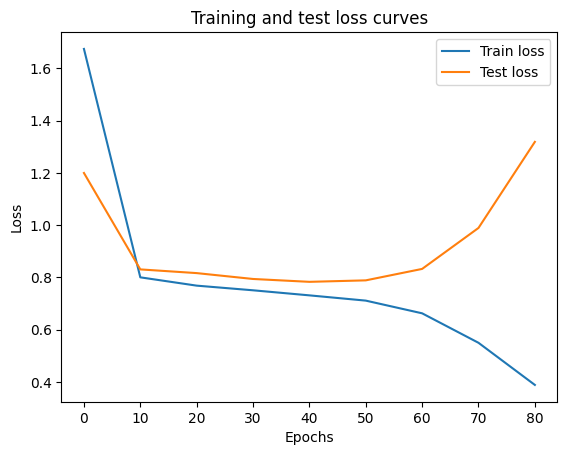

In [94]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Prediction

In [8]:
loaded_model = DLRegAlloc().to(device)
loaded_model.load_state_dict(torch.load(f="torch_version_CROSSENTROPYLOSS_12_09_best.pth"))

<All keys matched successfully>

In [9]:
test_csvs = ["test/baidu.csv", "test/gkarate.csv"]

x_pred_list = []
y_pred_list = []
seq_size = 100

for i,csv in enumerate(test_csvs):
    print(csv, "information:")
    
    seq = pd.read_csv(csv, header=None, low_memory=False)
    columns = seq.columns.tolist()
    #get the adj edges
    adj_edge = np.array(seq[columns[1:2*seq_size+1]])
    #get the colors
    data_color = np.array(seq[columns[2*seq_size+1:3*seq_size+1]])
    X = np.zeros((adj_edge.shape[0], data_color.shape[1], seq_size))
    X, Y = adBits(adj_edge, X, data_color)
    Y = updateLabelBits(X, Y)
    Y = np.eye(101, dtype='float32')[Y]
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)

    x_pred_list.append(X)
    y_pred_list.append(Y)

    print(x_pred_list[i].shape)
    print(y_pred_list[i].shape)  

import pickle

for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    loaded_model.eval()
    with torch.inference_mode():
        predicted = loaded_model(x_pred_list[i]) # torch.Size([1, 100, 101])
        predicted = torch.softmax(predicted, dim=2)
        # print("softmax后predicted shape: ", predicted.shape)
        predicted = predicted.clone().detach().cpu().numpy() # (100, 101)
        # print(predicted.shape) # (1, 100, 101)
        # print(np.argmax(predicted, axis=2)) # (1,100)

        x_pred = x_pred_list[i].clone().detach().cpu() # torch.Size([1, 100, 100])
        print('\nInvalid edges percentage before color correction ->')
        post_process(np.asarray(x_pred.tolist()), predicted)
        
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list_before_correction = post_process_chromatic(np.asarray(x_pred), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x_pred), predicted, colors_list_list_before_correction)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list_after_correction = post_process_chromatic(np.asarray(x_pred), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process(np.asarray(x_pred), predicted)
        results = create_csv_rows(csv.rsplit('/',-1)[-1], colors_list_list_before_correction, colors_list_list_after_correction)
        print(results)
        with open("results", "wb") as fp:   #Pickling
            pickle.dump(colors_list_list_after_correction, fp)
# import csv
# with open("Result/pytorch_graph_coloring_result.csv", 'w') as csvfile:
#     # creating a csv writer object
#     csvwriter = csv.writer(csvfile)      
#     # writing the data rows
#     csvwriter.writerows(csv_rows)

test/baidu.csv information:
torch.Size([1, 100, 100])
torch.Size([1, 100, 101])
test/gkarate.csv information:
torch.Size([1, 100, 100])
torch.Size([1, 100, 101])

------PREDICTING  test/baidu.csv -------

Invalid edges percentage before color correction ->
Total No of edges  91
# of edges with invalid coloring  21
Total percentage of edges with invalid colors  0.23076923076923078

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 2, 3, 1, 1, 5, 3, 3, 4, 6, 6, 5, 6, 1, 2, 2, 1, 2, 2, 3, 3, 3, 2, 1, 5, 4, 6, 1, 1, 7, 7, 2, 2, 3, 5, 6, 2, 5, 1, 3, 4, 4, 4, 4, 2, 3, 1, 9, 2, 2, 2, 5, 3, 6, 6, 6, 2, 6, 6, 10]
Chromatic number of graph  0  is   9

Apply color correction ->

Colors list and Chromatic number following color correction ->
Colors list of graph  0  is  
 [1, 2, 3, 1, 1, 5, 3, 3, 4, 6, 6, 5, 6, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2, 1, 5, 4, 6, 1, 3, 1, 7, 1, 2, 3, 5, 6, 2, 5, 1, 1, 4, 1, 4, 1, 2, 3, 2, 9, 2, 1, 2, 5, 1, 6, 1, 6, 2, 1, 6, 10]
Chr

In [11]:
import pickle
with open("results", "rb") as fp:
    color_list = pickle.load(fp)
print(color_list)

[[1, 2, 3, 4, 4, 4, 6, 7, 7, 2, 7, 6, 6, 7, 2, 2, 2, 6, 2, 6, 2, 3, 2, 2, 2, 3, 1, 1, 1, 3, 1, 7, 4, 5]]
